# More Dilution Experiment Controls 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import mscl.plotting
import mscl.process
import mscl.stats
import pandas as pd
import glob
import matlab.engine as matlab
colors = mscl.plotting.set_plotting_style()
eng = matlab.start_matlab()
%matplotlib inline

## The Experiment 

The goal of this noteboook is to perform some more troubleshooting with the dilution experiment using an experimental sample which had the 20ng/mL aTc removed via washing and one without any washing at all. I also look at data from an experiment in which here was no induction of the genetic circuit at all. 

For the washing experiment (20180105), the positions corresponded to the following samples:

| Position | Sample |
|---|---|
|0 - 9 | 20 ng/mL aTc washed 3x |
|10 - 19| 20 ng/mL aTc no wash |

Below, I will read in these cell files and separate them by these two experiments, as well as sload teh autofluorescence information

###  Loading the data

In [10]:
# Define the root directory for the data. 
root_dir = '../../data/images/20180105_sfGFP_20ngmL_dilution/'

# Grab all of the xy directories.
positions = glob.glob('{0}growth/xy*'.format(root_dir))

# Set up a storage vector for the dataframes.
dfs = []

# Loop through each position and process teh cell files.
for i, p in enumerate(positions):
    pos = int(p.split('/')[-1].split('xy')[1])
    # Grab all of the cell files.
    cell_files = glob.glob('{0}/cell/*.mat'.format(p))
   
    if pos <= 9:
        wash = True
    else:
        wash = False
    # Extract the data. 
    _df = mscl.process.parse_cell_files(cell_files, eng, add_props={'position': pos, 'wash': wash})

    # Add to the storage list.
    dfs.append(_df)
    
# Concatenate into a single dataframe. 
df = pd.concat(dfs, ignore_index=True)

We will also load teh autofluorescence data and the standard candle data, MLG910 

In [16]:
# Grab all autofluorescence files.
positions = glob.glob('{0}/autofluorescence/xy*'.format(root_dir))
dfs = []
for i, p in enumerate(positions):
    cell_files = glob.glob('{0}/cell/*.mat'.format(p))
    _df = mscl.process.parse_cell_files(cell_files, eng, excluded_props=['birth', 'death', 'death_fluo', 
                                                                        'daughter_1_ID', 'daughter_2_ID',
                                                                        'ID', 'motherID', 'death_area',
                                                                        'num_exposures'])
    dfs.append(_df)
auto = pd.concat(dfs, ignore_index=True)

# Grab all MLG910 images.
positions = glob.glob('{0}/mlg910/xy*'.format(root_dir))
dfs = []
for i , p in enumerate(positions):
    cell_files = glob.glob('{0}/cell/*.mat'.format(p))
    _df = mscl.process.parse_cell_files(cell_files, eng, excluded_props=['birth', 'death', 'death_fluo', 
                                                                        'daughter_1_ID', 'daughter_2_ID',
                                                                        'ID', 'motherID', 'death_area',
                                                                        'num_exposures'])
    dfs.append(_df)
    
mlg910 = pd.concat(dfs, ignore_index=True)

### Examining the distributions

It would be informative to see the distributions of the washed and unwashed sample at the first frame compared to the last frame. The distribution of the autofluorescence sample will also be overlaid.  

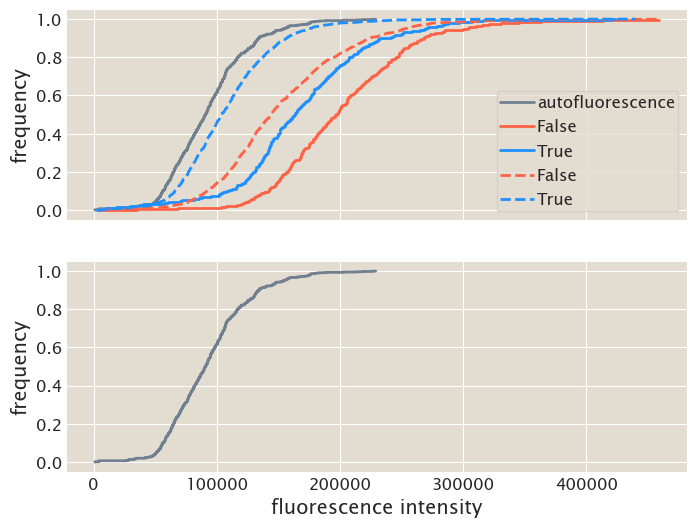

In [29]:
# Narrow the data frame to only the birth cells.
founders = df[df['birth']==1]

# Find the max death frame number.
final_frame = np.max(df['death'].unique())
finalists = df[df['death']==final_frame]

# Group by wash state.
founder_grouped = founders.groupby('wash')
finalists_grouped = finalists.groupby('wash')

# Set up the figure canvas.
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].set_ylabel('frequency')
ax[1].set_ylabel('frequency')
ax[1].set_xlabel('fluorescence intensity')


# Define the color palette.
colors = {True:'dodgerblue', False:'tomato'}

# Plot the autofluorescence distribution on each plot first.
# auto_hist, auto_bins = np.histogram(auto['birth_fluo'], bins=20, normed=True)
# ax[0].step(auto_bins[:-1], auto_hist, '-', color='slategray', label='autofluorescence')
# ax[1].step(auto_bins[:-1], auto_hist, '-', color='slategray')
auto_x, auto_y = mscl.stats.ecdf(auto['birth_fluo'])
ax[0].step(auto_x, auto_y, '-', color='slategray', label='autofluorescence')
ax[1].step(auto_x, auto_y, '-', color='slategray')

# Plot the founders first.
for g, d in founder_grouped:
    color = colors[g]
    x, y = mscl.stats.ecdf(d['death_fluo'])
    ax[0].step(x, y, '-', color=color, label=g)
#     hist, bins = np.histogram(d['birth_fluo'], bins=20, normed=True)
#     ax[0].step(bins[:-1], hist, '-', color=color, label=g)

   
# Now plot the finalists.
for g, d in finalists_grouped:
    color = colors[g]
    x, y = mscl.stats.ecdf(d['death_fluo'])
    ax[0].plot(x, y, '--', color=color, label=g)
#     hist, bins = np.histogram(d['birth_fluo'], bins=20, normed=True)
#     ax[1].step(bins[:-1], hist, '-', color=color)

ax[0].legend()


In [24]:
finalists

,birth,death,divide,ID,motherID,sisterID,daughter_1_ID,daughter_2_ID,birth_fluo,death_fluo,birth_area,death_area,num_exposures,position,wash
